## Base SCE circuit data

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

path = "../../data/raw/iou_sce/Available Load Capacity - Circuit.csv"

data = pd.read_csv(path)

data.head()

,SYSTEM NAME,SUBSTATION NAME,CIRCUIT NAME,CIRCUIT VOLTAGE,GNA ID,DATE OF LAST UPDATE,ALC 2023,ALC 2024,ALC 2025,ALC 2026,ALC 2027
0,Antelope,Acton 66/12 Kv,Bootlegger,12.0,NaN,07/24/2024,0.65,0.60,0.55,0.50,0.45
1,Antelope,Acton 66/12 Kv,Pick,12.0,NaN,07/24/2024,4.65,4.65,4.65,4.64,4.63
2,Antelope,Acton 66/12 Kv,Shovel,12.0,NaN,07/24/2024,2.62,2.60,2.58,2.55,2.53
3,Eagle Mountain,Aha P.T. 33/12 Kv,Aha,12.0,NaN,07/24/2024,0.79,0.80,0.81,0.81,0.81
4,Del Amo,Albury P.T. 12/4 Kv,Albury,4.0,NaN,07/24/2024,0.28,0.28,0.27,0.27,0.27


In [4]:
data.count()

SYSTEM NAME            4075
SUBSTATION NAME        4075
CIRCUIT NAME           4075
CIRCUIT VOLTAGE        4075
GNA ID                  281
DATE OF LAST UPDATE    4075
ALC 2023               4075
ALC 2024               4075
ALC 2025               4075
ALC 2026               4075
ALC 2027               4075
dtype: int64

In [5]:
lowest_capacity_circuit = data.loc[data['ALC 2024'] == 0.0]
lowest_capacity_circuit.count()
lowest_capacity_circuit.head()

circuit_names = lowest_capacity_circuit['CIRCUIT NAME'].tolist()
circuit_names

['Frisbie',
 'Enloe',
 'Paddock',
 'Valnett',
 'Haven',
 'Bravon',
 'Imbach',
 'Kropp',
 'Anzac',
 'Leon',
 'Heftler',
 'Clover',
 'Brooklyn',
 'Wilshire',
 'Green',
 'Serenity',
 'Flatcar',
 'Tender',
 'Lettuce',
 'Ohio',
 'Alberta',
 'Pinehurst',
 'Fiji',
 'Atlantic',
 'Colyer',
 'Pattie',
 'Overall',
 'Limonite',
 'Harlem Springs',
 'Seacliff',
 'Surfside',
 'Diplomat',
 'Palace',
 'Weirick',
 'Wyle',
 'Wyle',
 'Pineapple',
 'Globe Mills',
 'Preston',
 'Preston',
 'Taberna',
 'Anzar',
 'Mears',
 'Florence',
 'Otis',
 'Gravel',
 'Dixon',
 'Jot',
 'Pangborn',
 'Bowman',
 'Jonagold',
 'Clarinet',
 'Backdraft',
 'Hose',
 'Jessup',
 'Kadota',
 'Marbuck',
 'Boland',
 'Convex',
 'Pulp',
 'Ira',
 'Coachella',
 'Desert Crest',
 'Dillon',
 'Linda Vista',
 'San Rafael',
 'Blackhills',
 'Barney Lee',
 'Nadeau',
 'Squadron',
 'Norwood',
 'Sparks',
 'Miramonte',
 'Bacon',
 'Salt',
 'Cadence',
 'Burma',
 'Poker',
 'Yahtzee',
 'Fortress',
 'Havoc',
 'Hellcat',
 'Tigercat',
 'Warhawk',
 'Montrose',


## Geometries of Circuits

In [6]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer

feature_layer_url = 'https://services5.arcgis.com/z6hI6KRjKHvhNO0r/ArcGIS/rest/services/ICA_Layer/FeatureServer/1'
layer = FeatureLayer(feature_layer_url)
circuit_names_str = ",".join([f"'{c}'" for c in circuit_names])
query = layer.query(where=f"CIRCUIT_NAME IN ({circuit_names_str})", out_fields='*', return_geometry=True)

geospatial_data = query.sdf

/opt/homebrew/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Exception: Cannot perform query. Invalid query parameters.
'Invalid field: CIRCUIT_NAME' parameter is invalid
(Error Code: 400)

In [ ]:
lowest_capacity_circuit['CIRCUIT_NAME'] = lowest_capacity_circuit['CIRCUIT NAME'].str.upper()  # Ensure matching case
geospatial_data['CIRCUIT_NAME'] = geospatial_data['CIRCUIT_NAME'].str.upper()  # Ensure matching case

print("Circuit Data Columns:", lowest_capacity_circuit.columns)
print("Geospatial Data Columns:", geospatial_data.columns)

Circuit Data Columns: Index(['SYSTEM NAME', 'SUBSTATION NAME', 'CIRCUIT NAME', 'CIRCUIT VOLTAGE',
       'GNA ID', 'DATE OF LAST UPDATE', 'ALC 2023', 'ALC 2024', 'ALC 2025',
       'ALC 2026', 'ALC 2027', 'CIRCUIT_NAME'],
      dtype='object')
Geospatial Data Columns: Index(['CHANGED_DATE', 'DOWNLOAD_LINK_MICROGRID', 'ICA_OVERALL_PV_OP_FLEX',
       'UNIFORM_GENERATION_OP_FLEX', 'CIRCUIT_NAME', 'CIRCUIT_VOLTAGE',
       'DISCLAIMER', 'DOWNLOAD_LINK', 'ICA_OVERALL_LOAD', 'ICA_OVERALL_PV',
       'NODE_ID', 'NOTE', 'PHASE', 'SECTION_ID', 'SUBSTATION_NAME',
       'SUBSTATION_VOLTAGE', 'SYSTEM_NAME', 'UNIFORM_GENERATION', 'OBJECTID',
       'Shape__Length', 'SHAPE'],
      dtype='object')


In [ ]:
lowest_capacity_circuit = lowest_capacity_circuit.reset_index(drop=True)
geospatial_data = geospatial_data.reset_index(drop=True)

merged_data = lowest_capacity_circuit.merge(geospatial_data, on='CIRCUIT_NAME', how='left')

merged_data.head()

# merged_data.to_csv('sce_lowcapacity_circuit_geospatial_details.csv', index=False)


,SYSTEM NAME,SUBSTATION NAME,CIRCUIT NAME,CIRCUIT VOLTAGE,GNA ID,DATE OF LAST UPDATE,ALC 2023,ALC 2024,ALC 2025,ALC 2026,...,NOTE,PHASE,SECTION_ID,SUBSTATION_NAME,SUBSTATION_VOLTAGE,SYSTEM_NAME,UNIFORM_GENERATION,OBJECTID,Shape__Length,SHAPE
0,Etiwanda,Alder 66/12 Kv,Frisbie,12.0,NaN,07/24/2024,2.29,0.0,0.0,0.0,...,<NA>,3,49159987.0,Alder,66/12 kV,Etiwanda 220/66 System,0.0,3889,320.213469,"{""paths"": [[[1529637.83773866, 12391659.684678..."
1,Etiwanda,Alder 66/12 Kv,Frisbie,12.0,NaN,07/24/2024,2.29,0.0,0.0,0.0,...,<NA>,3,49159662.0,Alder,66/12 kV,Etiwanda 220/66 System,0.0,3890,194.602845,"{""paths"": [[[1527600.25191883, 12394183.614341..."
2,Etiwanda,Alder 66/12 Kv,Frisbie,12.0,NaN,07/24/2024,2.29,0.0,0.0,0.0,...,<NA>,3,49160563.0,Alder,66/12 kV,Etiwanda 220/66 System,<NA>,3891,458.300942,"{""paths"": [[[1529737.06883941, 12389632.508942..."
3,Etiwanda,Alder 66/12 Kv,Frisbie,12.0,NaN,07/24/2024,2.29,0.0,0.0,0.0,...,<NA>,3,49159422.0,Alder,66/12 kV,Etiwanda 220/66 System,<NA>,53214,287.379822,"{""paths"": [[[1527827.40238316, 12393106.708031..."
4,Etiwanda,Alder 66/12 Kv,Frisbie,12.0,NaN,07/24/2024,2.29,0.0,0.0,0.0,...,<NA>,3,49159486.0,Alder,66/12 kV,Etiwanda 220/66 System,<NA>,53215,259.085189,"{""paths"": [[[1527898.89206958, 12393503.464127..."


# Prepare SCE Feeder / Circuits data

Circuit Data Columns: Index(['SYSTEM NAME', 'SUBSTATION NAME', 'CIRCUIT NAME', 'CIRCUIT VOLTAGE',
       'GNA ID', 'DATE OF LAST UPDATE', 'ALC 2023', 'ALC 2024', 'ALC 2025',
       'ALC 2026', 'ALC 2027', 'CIRCUIT_NAME'],
      dtype='object')
Geospatial Data Columns: Index(['CHANGED_DATE', 'DOWNLOAD_LINK_MICROGRID', 'ICA_OVERALL_PV_OP_FLEX',
       'UNIFORM_GENERATION_OP_FLEX', 'CIRCUIT_NAME', 'CIRCUIT_VOLTAGE',
       'DISCLAIMER', 'DOWNLOAD_LINK', 'ICA_OVERALL_LOAD', 'ICA_OVERALL_PV',
       'NODE_ID', 'NOTE', 'PHASE', 'SECTION_ID', 'SUBSTATION_NAME',
       'SUBSTATION_VOLTAGE', 'SYSTEM_NAME', 'UNIFORM_GENERATION', 'OBJECTID',
       'Shape__Length', 'SHAPE'],
      dtype='object')


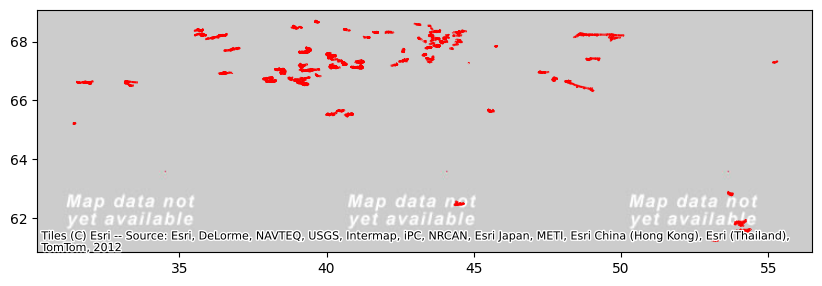

In [ ]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS

feature_layer_url = 'https://services5.arcgis.com/z6hI6KRjKHvhNO0r/ArcGIS/rest/services/ICA_Layer/FeatureServer/1'
layer = FeatureLayer(feature_layer_url)

circuit_names = lowest_capacity_circuit['CIRCUIT NAME'].tolist()

circuit_names_str = ",".join([f"'{c}'" for c in circuit_names])

query = layer.query(where=f"CIRCUIT_NAME IN ({circuit_names_str})", out_fields='*', return_geometry=True)
geospatial_data = query.sdf

lowest_capacity_circuit['CIRCUIT_NAME'] = lowest_capacity_circuit['CIRCUIT NAME'].str.upper()
geospatial_data['CIRCUIT_NAME'] = geospatial_data['CIRCUIT_NAME'].str.upper()

print("Circuit Data Columns:", lowest_capacity_circuit.columns)
print("Geospatial Data Columns:", geospatial_data.columns)

merged_data = pd.merge(lowest_capacity_circuit, geospatial_data, on='CIRCUIT_NAME', how='left')

# Function to convert paths to LineString
def paths_to_linestring(shape):
    if isinstance(shape, dict) and 'paths' in shape:
        paths = shape['paths']
        flattened = [tuple(coord) for path in paths for coord in path]
        return LineString(flattened)
    return None

merged_data['geometry'] = merged_data['SHAPE'].apply(paths_to_linestring)

# Drop rows with invalid geometries
merged_data = merged_data.dropna(subset=['geometry'])

gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Set the coordinate reference system (CRS) to NAD_1983_UTM_Zone_11N
gdf.set_crs(CRS.from_epsg(26911), inplace=True)

# Transform to WGS84 (lat/lon) for plotting on the basemap
gdf = gdf.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red')

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

plt.show()


In [ ]:
import requests
import geopandas as gpd
import pandas as pd

feature_layer_url = 'https://services5.arcgis.com/z6hI6KRjKHvhNO0r/ArcGIS/rest/services/ICA_Layer/FeatureServer/3/query'

params = {
    'where': '1=1',
    'outFields': '*',
    'f': 'geojson'
}

response = requests.get(feature_layer_url, params=params)
data = response.json()

gdf = gpd.GeoDataFrame.from_features(data["features"])

# Set the CRS to the original CRS specified in the data
gdf.set_crs(epsg=26911, inplace=True)  # NAD83 / UTM zone 11N

path = "../data/raw/iou_sce/Available Load Capacity - Circuit.csv"
csv_data = pd.read_csv(path)

low_capacity_circuits = csv_data[csv_data['ALC 2024'] == 0][['SUBSTATION NAME', 'CIRCUIT NAME', 'ALC 2024']]

merged_data = gdf.merge(low_capacity_circuits, how='inner', left_on='CIRCUIT_NAME', right_on='CIRCUIT NAME')

result_df = merged_data[['SUBSTATION NAME', 'CIRCUIT_NAME', 'ALC 2024', 'geometry']]
result_df.columns = ['Substation Name', 'Circuit Name', 'ALC 2024', 'Geometry']

print(result_df)
result_df.to_csv('../data/processed/sce_0_available_load_capacity_2024_circuits.csv', index=False)


         Substation Name Circuit Name  ALC 2024  \
0       Imperial 66/4 Kv        Bacon       0.0   
1         Temple 16/4 Kv      Bidwell       0.0   
2       Brewster 16/4 Kv      Alberta       0.0   
3         Upland 66/4 Kv         Barr       0.0   
4   San Antonio 66/12 Kv     Baseline       0.0   
..                   ...          ...       ...   
83      Stewart 66/12 Kv        Jimmy       0.0   
84   Signal Hill 12/4 Kv     Michigan       0.0   
85      Brewster 16/4 Kv    Pinehurst       0.0   
86        Muscoy 33/4 Kv        Power       0.0   
87     Highland 66/12 Kv      Norwood       0.0   

                                             Geometry  
0   MULTILINESTRING ((-118.141 33.908, -118.140 33...  
1   MULTILINESTRING ((-118.062 34.103, -118.061 34...  
2   MULTILINESTRING ((-118.192 33.932, -118.192 33...  
3   LINESTRING (-117.650 34.093, -117.650 34.094, ...  
4   MULTILINESTRING ((-117.698 34.106, -117.698 34...  
..                                                .

In [8]:
import requests
import geopandas as gpd
import pandas as pd

# Define the feature layer URL
feature_layer_url = 'https://services5.arcgis.com/z6hI6KRjKHvhNO0r/ArcGIS/rest/services/ICA_Layer/FeatureServer/3/query'

# Query parameters
params = {
    'where': '1=1',
    'outFields': '*',
    'f': 'geojson'
}

response = requests.get(feature_layer_url, params=params)
data = response.json()

gdf = gpd.GeoDataFrame.from_features(data["features"])

# Set the CRS to the original CRS specified in the data
gdf.set_crs(epsg=26911, inplace=True)  # NAD83 / UTM zone 11N

path = "../../data/raw/iou_sce/Available Load Capacity - Circuit.csv"
csv_data = pd.read_csv(path)

valid_capacity_circuits = csv_data[csv_data['ALC 2024'] > 0][['SUBSTATION NAME', 'CIRCUIT NAME', 'ALC 2024']]

merged_data = gdf.merge(valid_capacity_circuits, how='inner', left_on='CIRCUIT_NAME', right_on='CIRCUIT NAME')

sorted_data = merged_data.sort_values(by='ALC 2024', ascending=False)

top_100_circuits = sorted_data.head(100)

less_than_1_mw = sorted_data[sorted_data['ALC 2024'] < 1000.0]

print(len(less_than_1_mw))

result_df = top_100_circuits[['SUBSTATION NAME', 'CIRCUIT_NAME', 'ALC 2024', 'geometry']]
result_df.columns = ['Substation Name', 'Circuit Name', 'ALC 2024', 'Geometry']

print(result_df)

# result_df.to_csv('../../data/processed/top_100_sce_circuits_by_capacity_2024.csv', index=False)


1947
        Substation Name Circuit Name  ALC 2024  \
1740     Crest 66/16 Kv         Mica      9.64   
1739     Crest 66/16 Kv         Mica      9.64   
1738     Crest 66/16 Kv         Mica      9.64   
1153    Gisler 66/12 Kv        Viper      8.39   
1035     Vegas 66/16 Kv       Gaucho      8.20   
...                 ...          ...       ...   
1117    Bovine 66/12 Kv         Zebu      5.35   
434   Stadler 115/12 Kv   Linebacker      5.23   
1196   Skiland 33/12 Kv       Nordic      5.11   
1194   Skiland 33/12 Kv       Nordic      5.11   
1195   Skiland 33/12 Kv       Nordic      5.11   

                                               Geometry  
1740  LINESTRING (-118.390 33.756, -118.390 33.756, ...  
1739      LINESTRING (-118.392 33.761, -118.392 33.761)  
1738      LINESTRING (-118.366 33.762, -118.366 33.761)  
1153  LINESTRING (-117.904 33.699, -117.904 33.699, ...  
1035  LINESTRING (-119.832 34.446, -119.832 34.446, ...  
...                                           